In [191]:
import numpy as np
import math

In [192]:
G = 10E9

carrier_frequency = 2 * G

g1, g2, g3, g4 = 32.4, 14, 15, 0.5 

w = 20

n_users_floor = 20

height_floors = 5

coordinates_uav = [0, 0, 0]

users_positions_xy = np.full((10, 3), fill_value=[1,1,1])
users_positions_xz = np.full((10, 3), fill_value=[1,1,1])

In [193]:
x_coordinates = np.arange(0,10)
y_coordinates = np.arange(0,10)
z_coordinates = np.arange(0,10)

np.random.shuffle(x_coordinates)
np.random.shuffle(y_coordinates)
np.random.shuffle(z_coordinates)

for i in range(len(users_positions_xy)):
    users_positions_xy[i][0] = x_coordinates[i]
    users_positions_xy[i][2] = 10 / 2
    users_positions_xy[i][1] = y_coordinates[i]

for i in range(len(users_positions_xz)):
    users_positions_xz[i][0] = x_coordinates[i]
    users_positions_xz[i][2] = y_coordinates[i]
    users_positions_xz[i][1] = 10 / 2

We can see how the users are spreaded throughout the building by plotting
each user as a dot on a plane.

Text(0.5, 0, 'Z')

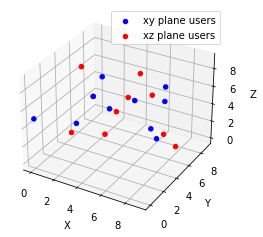

In [194]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

[x_plot_xy, y_plot_xy, z_plot_xy] = users_positions_xy.T
[x_plot_xz, y_plot_xz, z_plot_xz] = users_positions_xz.T

ax.scatter(x_plot_xy, y_plot_xy, z_plot_xy, alpha=1, color='blue', label='xy plane users')
ax.scatter(x_plot_xz, y_plot_xz, z_plot_xz, alpha=1, color='red', label='xz plane users')

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


The theorems showed in the paper tell us that the best coordinates y and z for the uav
are equal to half of they magnitude. Now, there's only one coordinate remaining until
we can find the best position of our uav: the x coordinate

In [195]:
coordinates_uav[1] = 10 / 2
coordinates_uav[2] = 10 / 2

In [214]:
def calculate_distance_drone_users(coordinates_uav, users_positions):
    distance_drone_users = []
    for i in range(len(users_positions)):
        distance_drone_user = np.linalg.norm(users_positions[i] - coordinates_uav)
        distance_drone_users.append(distance_drone_user)
    return distance_drone_users


In [215]:
def calculate_angle_users(users_position, coordinates_uav, distance_drone_users):
    angle_users= []
    for i in range(len(users_position)):
        angle_user = np.arccos( ( ((coordinates_uav[0] - users_position[i][0]) ** 2 + (coordinates_uav[1] - users_position[i][1]) ** 2) ** 0.5 )/distance_drone_users[i])
        angle_users.append(angle_user)
    return angle_users

Defines the Loss function to be optimized in order to minimize the transmit power


In [216]:
def loss(coordinates_uav, w, distance_drone_users, users_coordinates , angle_users, g1, g2, g3, g4, frequency):
    loss = 0
    for i in range(len(distance_drone_users)):
        k = w * math.log10(frequency) + g1 + g2 + g4 * np.linalg.norm(users_coordinates[i][0:2] - 
        coordinates_uav[0:2])
        loss += w * np.log10(distance_drone_users[i]) + g3 * (1 - np.cos(angle_users[i]) ** 2) + k 
    return loss

In [253]:
print(coordinates_uav[0:3])

[0, 5.0, 5.0]


Plot the loss function for the problem


In [278]:
def gradient(uav_coordinates, distance_drone_users, users_coordinates, w, g3):
    gradient_value = 0
    for i in range(len(users_coordinates)):
        gradient_value += (- w * (users_coordinates[i][0] - uav_coordinates[0]) / (math.log(10) 
        * distance_drone_users[i] ** 2)) + 2 * g3 * (1 - np.linalg.norm( 
            users_coordinates[i][0:2] - uav_coordinates[0:2]) / distance_drone_users[i])  - ((np.linalg.norm(
                        users_coordinates[i][0:2] - uav_coordinates[0:2]) * (users_coordinates[i][0] - 
                        uav_coordinates[0]) * distance_drone_users[i] ** -1) / distance_drone_users[i] ** 2)
    return gradient_value
    

In [279]:
x_uav_n, x_uav = 0 ,0 
max_iterations = 10000
step_size = 0.01
tolerance = 0.0000001
i = 0
steps = []
users_positions = np.concatenate((users_positions_xy, users_positions_xz), axis=0)
while i < max_iterations:
    x_uav = x_uav_n
    coordinates_uav[0] = x_uav
    distance_drone_users = calculate_distance_drone_users(coordinates_uav, users_positions)
    gradient_value = gradient(coordinates_uav, distance_drone_users, users_positions, w, g3)  
    x_uav_n = x_uav - step_size * gradient_value
    print(gradient_value)
    print(x_uav_n)
    break
    steps.append(x_uav_n)
    previous_step_size = abs(x_uav - x_uav_n)
    if abs(gradient_value) <= tolerance:
        break
    i += 1  
#print(steps, file=open('gradient.txt', 'w'))

-23.17007150949217
0.2317007150949217


In [187]:
print("optimum value: " + str(x_uav_n) + "m")

optimum value: 0.42445220148930324m


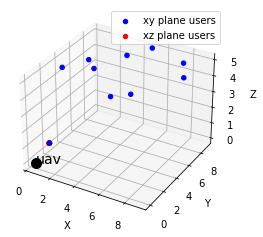

In [188]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

[x_plot_xy, y_plot_xy, z_plot_xy] = users_positions_xy.T
[x_plot_xz, y_plot_xz, z_plot_xz] = users_positions_xz.T

ax.scatter(x_plot_xy, y_plot_xy, z_plot_xy, alpha=1, color='blue', label='xy plane users')
ax.scatter(x_plot_xz, y_plot_xz, z_plot_xz, alpha=1, color='red', label='xz plane users')
ax.scatter(coordinates_uav[0], coordinates_uav[1], coordinates_uav[2], alpha=1, color='black', s=100)
ax.text(coordinates_uav[0], coordinates_uav[1], coordinates_uav[2], "uav", color='black', fontsize=14)
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.savefig('graphs/graph_uav.jpg')


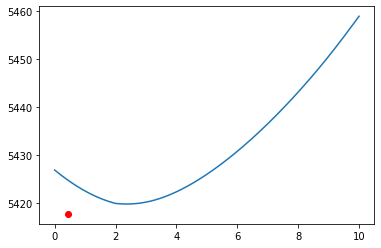

In [190]:
import matplotlib.animation as manimation

n = 500

angle_users = calculate_angle_users(users_positions, coordinates_uav, distance_drone_users)

x = np.linspace(0, 10, num=n)
coordinates_uav_test = list(map(lambda x: [x, 5, 5], x))
steps_loss = list(map(lambda step: loss([step, 5, 5], w, distance_drone_users,
    users_positions,angle_users, g1, g2, g3, g4, carrier_frequency), steps))
y = []
for coordinate in coordinates_uav_test:
    y.append(loss(coordinate, w, distance_drone_users,users_positions,angle_users, g1, g2, g3, g4, carrier_frequency))

fig = plt.figure()
loss_function_graph,  = plt.plot(x, y)
gradient_steps_plot,  = plt.plot([], [], 'ro', markersize='10')
text_plot = plt.text(0, 0, '')
optimal_point = plt.scatter(coordinates_uav[0], loss(coordinates_uav, w, distance_drone_users,users_positions,angle_users, g1, g2, g3, g4, carrier_frequency)
    , color='red')

# plt.axhline(y=min(y), color='r', linestyle='-')

#plt.savefig('graphs/gradient_descent.jpg')

In [ ]:
# Define the meta data for the movie
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='a red circle following a blue sine wave')
writer = FFMpegWriter(fps=15, metadata=metadata)

# Update the frames for the movie
with writer.saving(fig, "animacao_lamartine.mp4", 100):
    for i in range(len(steps)):
        x0 = steps[i]
        y0 = steps_loss[i]
        text_plot.set_x(x0)
        text_plot.set_y(y0)
        text_plot.set_text('y value: {y0}'.format(y0=y0))
        gradient_steps_plot.set_data(x0, y0)
        writer.grab_frame()